In [1]:
#!pip instal hide_code

In [2]:
from collections import Counter
from datetime import datetime, timedelta, date
from functools import reduce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display

from util.config import versioned
from util.polish import TERYT
from scrapers.pkw.sources import election_date
from analysis.utils import drop_duplicates, read_enriched, extract_companies

In [3]:
teryt = "12"

In [4]:
local_good = read_enriched(teryt)
print(f"Znaleziono {len(local_good)} osób")

Missing teryt: {'3209', '0264', '7293', '2468', '2401', '4930', '0619', '2606', '1602', '1424', '0600', '8566', '3526', '3063', '6710', '8510', '3500', '3569', '7225', '2469', '1426', '2954', '2731', '2416', '0804', '0661', '1463', '7105', '0208', '2760', '4967', '0612', '0225', '1436', '1431', '5367', '7129', '0602', '2465', '0609', '1465', '2478', '2924', '0207', '2413', '0615', '3021', '4914', '1610', '0411', '2461', '0214', '1414', '2400', '2215', '2404', '3568', '1811', '4954', '2817', '0605', '0200', '4959', '4926', '1571', '3523', '3206', '4910', '4964', '1802', '2601', '8512', '2739', '9300'}
Znaleziono 354 osób


In [5]:
local_good[local_good["krs_name"] == "Jacek Adam Boczkaja"]["election_before_work"]

Series([], Name: election_before_work, dtype: timedelta64[ns])

In [6]:
local_companies = pd.DataFrame(extract_companies(local_good), columns=["KRS", "Nazwa", "Liczba ciekawych osób"])
display(local_companies)

,KRS,Nazwa,Liczba ciekawych osób
0,0000053654,MAŁOPOLSKA ORGANIZACJA TURYSTYCZNA w Kraków,20
1,0000085822,TARNOWSKIE WODOCIĄGI w Tarnów,11
2,0000058058,KRAKOWSKI PARK TECHNOLOGICZNY w Kraków,11
3,0000232646,MIEJSKIE PRZEDSIĘBIORSTWO ENERGETYKI CIEPLNEJ ...,10
4,0000008522,MIĘDZYNARODOWY PORT LOTNICZY IM. JANA PAWŁA II...,10
5,0000076369,MIEJSKIE PRZEDSIĘBIORSTWO KOMUNIKACYJNE w Tarnów,9
6,0000056964,UZDROWISKO KRYNICA-ŻEGIESTÓW w Krynica-Zdrój,8
7,0000245701,POLSKA GRUPA OPAKOWANIOWA OPAKOMET w Kraków,8
8,0000056473,0000056473,7
9,0000461460,0000461460,7


In [7]:
komitet_counter = Counter((elt["party"] or "").lower().strip()
        for array in local_good["elections"].to_list()
        for elt in array)
komitet_counter.most_common(5)

[('komitet wyborczy prawo i sprawiedliwość', 89),
 ('komitet wyborczy akcja wyborcza solidarność', 49),
 ('komitet wyborczy platforma obywatelska rp', 48),
 ('', 37),
 ('komitet wyborczy polskie stronnictwo ludowe', 26)]

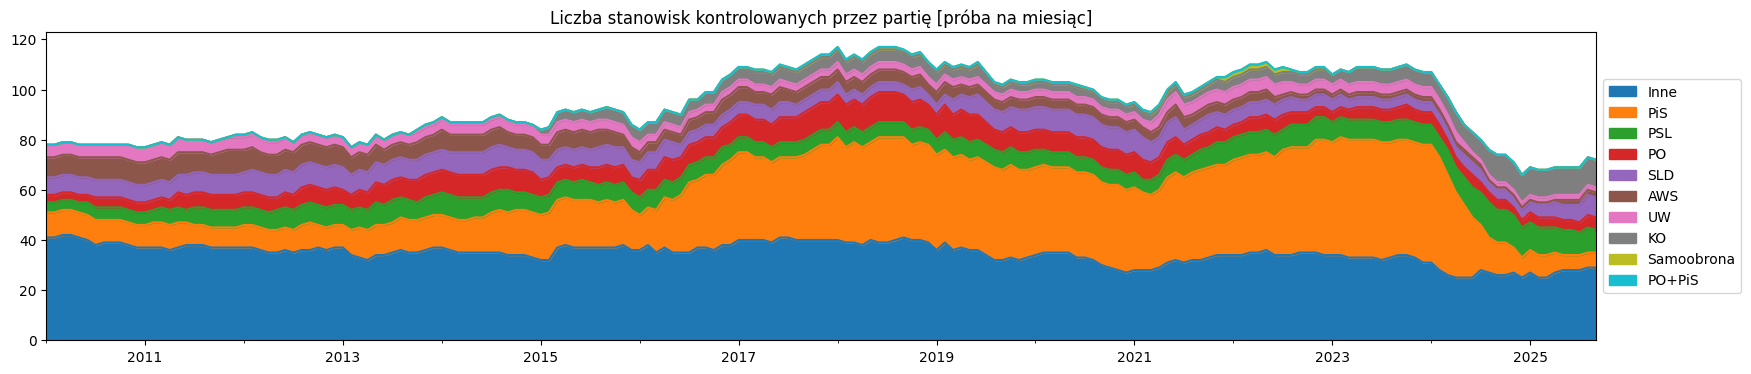

In [8]:
all_parties = set(party for parties in local_good["parties_simplified"].to_list() for party in parties)
local = {
 'Blok Samorządowy Razem',
 'Edward Pietrzyk',
 'Razem dla Radomska',
 'Razem dla Skierniewic',
 'Zbigniew Burzyński',
 'Ziemia Bełchatowska',
 'KWW Plus',
}
parties = all_parties - local
# display(parties)

def party_day_score(row):
    date = row.name
    result = [0] * len(row.index)
    global local_good
    for _i, _row in local_good.iterrows():
        for emp in _row["employment"]:
            duration = timedelta(days=365 * float(emp["employed_for"]))
            start_employed: date = emp["employed_end"] - duration
            if start_employed <= date.date() <= emp["employed_end"]:
                found_a_party = True
                for idx, col in enumerate(row.index):
                    if col in _row["parties_simplified"]:
                        result[idx] += 1
                        break
                else:
                    found_a_party = False
                if not found_a_party:
                    # Add them to "Inne" section
                    result[-1] += 1
    return pd.Series(result)

parties_aggregated = None

def show_graph(unit, unit_name, start='2010/01/01', end='2025/10/01'):
    dates = pd.date_range(start=start, end=end, freq=unit)
    df = pd.DataFrame({
        party: np.random.rand(len(dates)) for party in parties | set(["Inne"])
    }, index=dates)
    # Order dataframe columns by most recent, so we will return only at once
    df = df[["PiS","KO","PO","PSL","SLD","PO+PiS","Samoobrona","AWS","UW","Inne"]]
    # display(df)
    
    party_stats = pd.DataFrame({}, columns=df.columns)
    party_stats[df.columns] = df.apply(party_day_score, axis=1)
    global parties_aggregated
    parties_aggregated = party_stats.sum(0).sort_values(ascending=False)
    descending_party_popularity = parties_aggregated.index
    party_stats = party_stats[descending_party_popularity]
    # display(party_stats)
    
    ax = party_stats.plot.area(figsize=(20, 4))
    ax.set_title(f"Liczba stanowisk kontrolowanych przez partię [próba na {unit_name}]")
    ax.legend(loc="center left", bbox_to_anchor=(1.0,0.5))

show_graph("ME", "miesiąc")

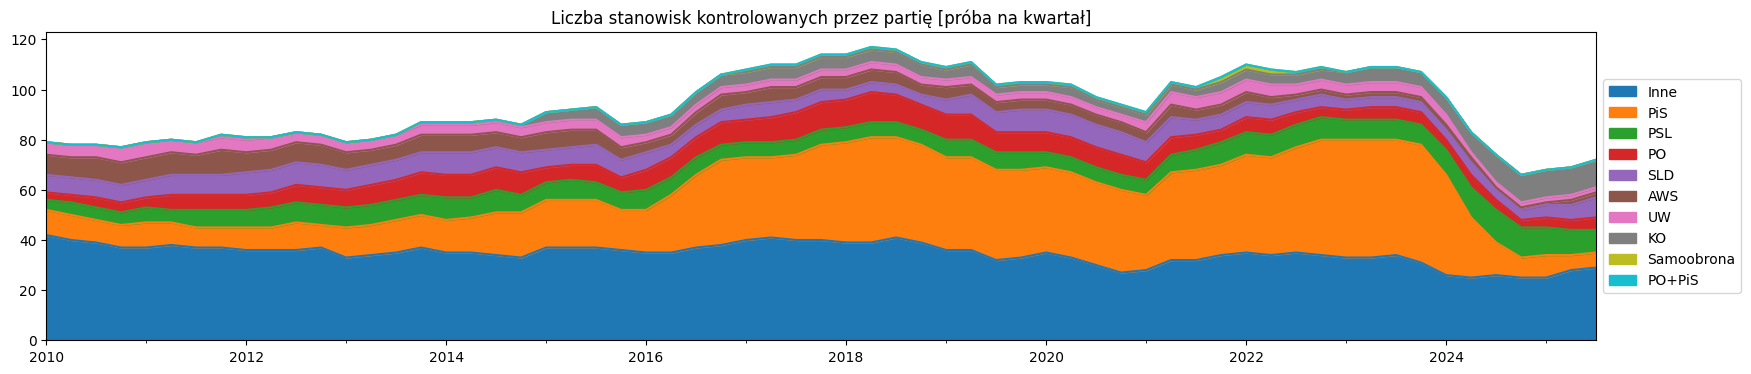

In [9]:
show_graph("QE", "kwartał")

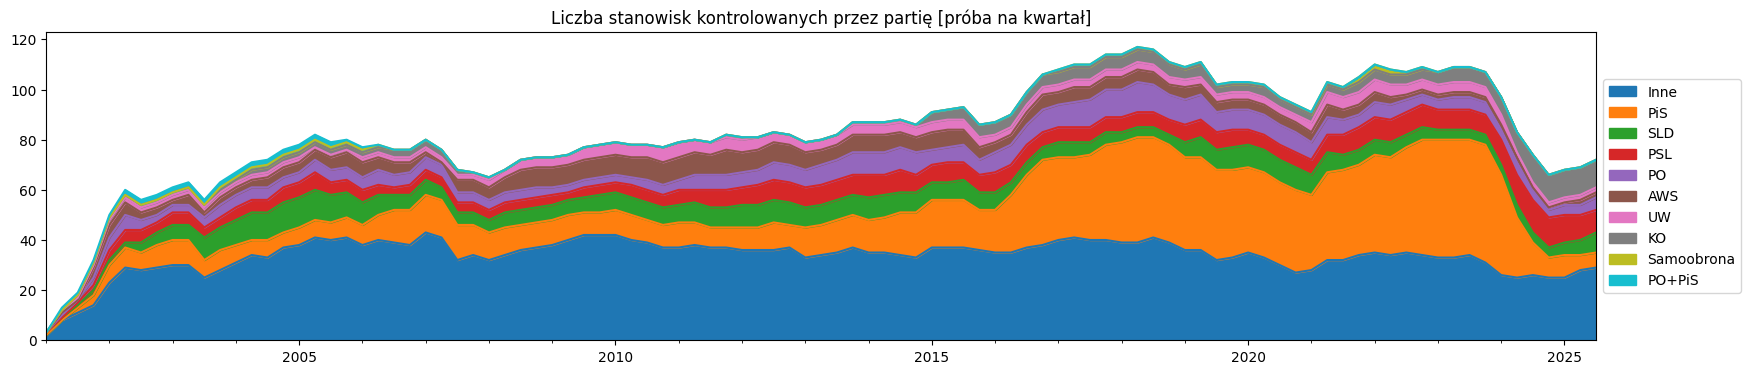

In [10]:
show_graph("QE", "kwartał", start="2001/01/01")

Text(0.5, 1.0, 'Łączny czas kontroli przez partie')

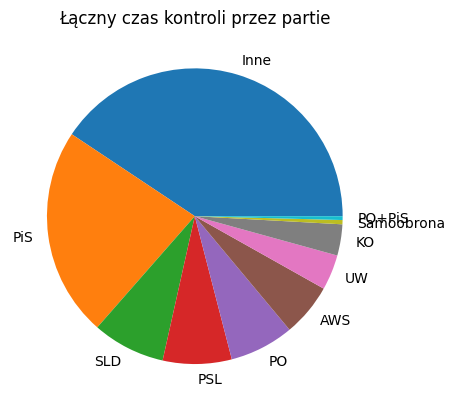

In [11]:
ax = parties_aggregated.plot.pie()
ax.set_title("Łączny czas kontroli przez partie")

Text(0.5, 0, 'Data ostatniego zatrudnienia')

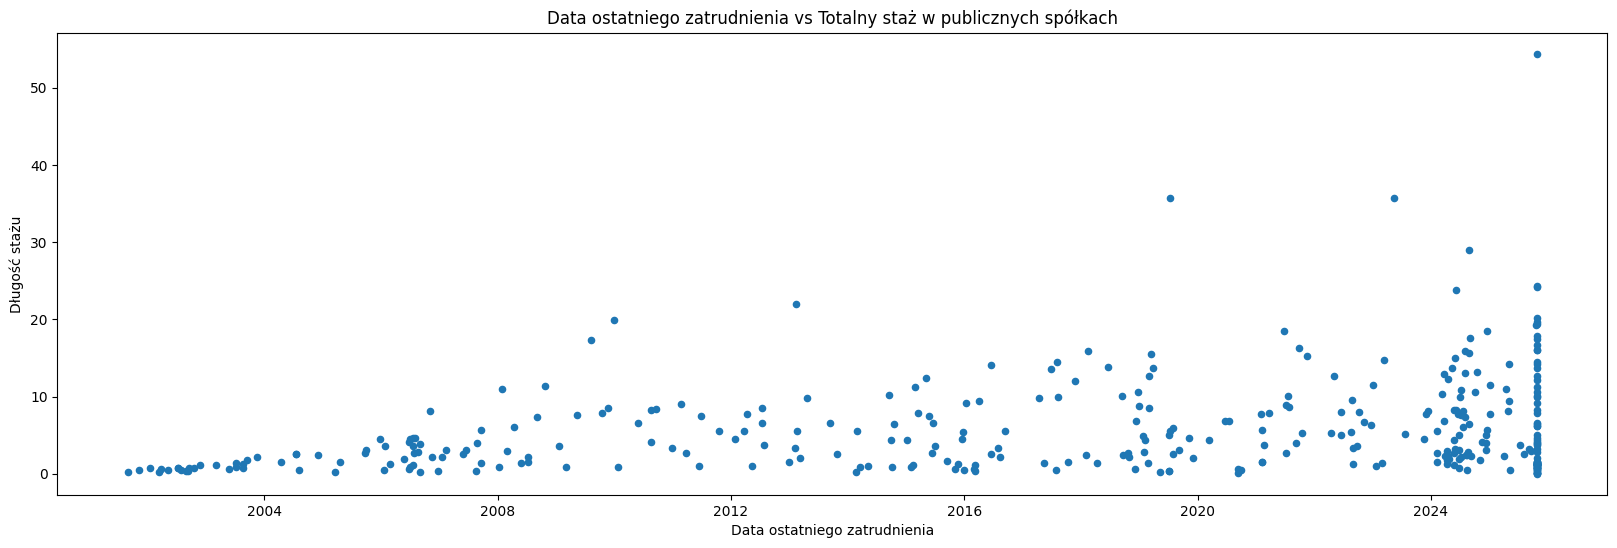

In [12]:
local_good["employed_total_years"] = local_good[("employed_total")].apply(lambda d: d.days / 365)
ax = local_good[["last_employed", "employed_total_years"]].plot.scatter(x="last_employed", y="employed_total_years", style=".", figsize=(20, 6))
ax.set_title("Data ostatniego zatrudnienia vs Totalny staż w publicznych spółkach")
ax.set_ylabel("Długość stażu")
ax.set_xlabel("Data ostatniego zatrudnienia")

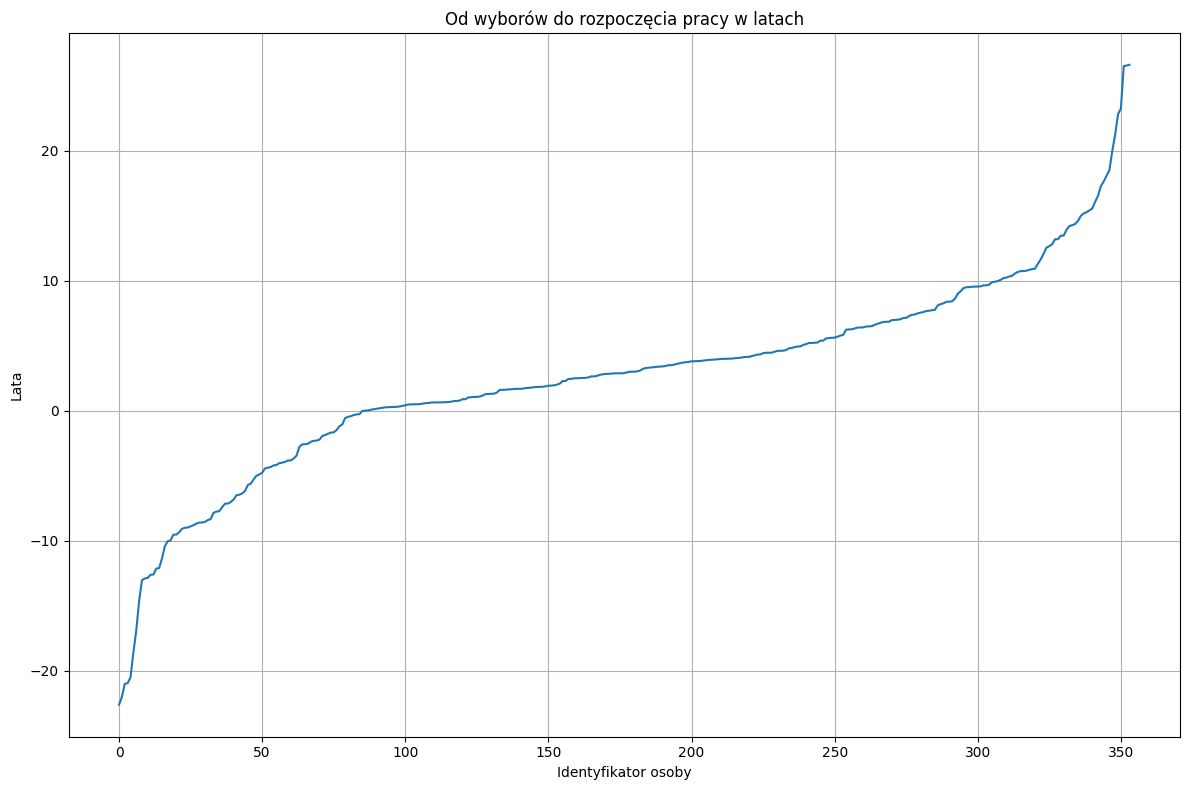

In [13]:
plt.figure(figsize=(12, 8))
ax = local_good["election_before_work"].apply(lambda duration: duration.days / 365).plot()
ax.set_xlabel("Identyfikator osoby")
ax.set_ylabel("Lata")
ax.grid(True)
ax.set_title("Od wyborów do rozpoczęcia pracy w latach")
plt.tight_layout()
plt.show()

In [14]:
d = date(year=1, month=1, day=1)
zero_delta = d - d

local_good["election_before_work_years"] = local_good["election_before_work"].apply(lambda d: d.days / 365)
longest_dur = local_good["election_before_work_years"].max()  # Use it, to put negative values after positive values of this column
local_good["election_before_work_normalized"] = local_good["election_before_work_years"].apply(lambda d: -d + longest_dur if d < 0 else d)

def calculate_position(column, smallest_good):
    # print(column)
    sort_series = local_good[column].sort_values(ascending=smallest_good)
    # display(sort_series)
    index_position = pd.Series(index=sort_series.index, data=range(len(sort_series)))
    # display(index_position)
    index_ordered = index_position.sort_index()
    # display(index_ordered)
    return index_ordered

a = calculate_position("election_before_work_normalized", smallest_good=True)
b = calculate_position("mistake_odds", smallest_good=False)
c = calculate_position("employed_total_years", smallest_good=False)
d = calculate_position("last_employed", smallest_good=False)

local_good["position"] = a + b + c +d
local_good.sort_values(by="position", inplace=True)

polish_headers = ["Pozycja", "Imię i nazwisko", "Data urodzenia", "Szansa na błąd - jeden na ...", "Od wyborów do pracy [lata]", "Łączny staż [lata]", "Ostatnie zatrudnienie", "Historia"]
cleaned = pd.DataFrame({}, columns=polish_headers)
cleaned[polish_headers] = local_good[["position", "krs_name", "birth_date", "mistake_odds", "election_before_work_years", "employed_total_years", "last_employed", "history"]]

display(cleaned.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None)

,Pozycja,Imię i nazwisko,Data urodzenia,Szansa na błąd - jeden na ...,Od wyborów do pracy [lata],Łączny staż [lata],Ostatnie zatrudnienie,Historia
114,104,Adam Maria Udziela,1946-05-10,43513039877975.804688,0.671233,14.268493,2025-10-26,Kandyduje w 1998 z list Krajowy Komitet Wyborczy Przymierze Społeczne: PSL-UP-KPEiR w Kraków Kandyduje w 2010 z list KOMITET WYBORCZY WYBORCÓW JACKA MAJCHROWSKIEGO w Kraków Pracuje od 2011-07-24 do 2025-10-26 w ARENA KRAKÓW w Kraków
167,219,Jacek Piotr Guzicki,1972-10-06,16008785806.119696,2.701370,18.479452,2024-12-17,"Kandyduje w 2014 z list Komitet Wyborczy Prawo i Sprawiedliwość w powiat krakowski Pracuje od 2017-08-03 do 2024-12-17 w KRAKÓW AIRPORT HOTEL w Balice Pracuje od 2018-11-15 do 2024-11-16 w MPL SERVICES w Balice Pracuje od 2019-02-02 do 2024-03-04 w KOPALNIA WAPIENIA ""CZATKOWICE"" w Krzeszowice"
146,252,Stanisław Kłysz,1962-09-23,39901089.547826,1.843836,16.027397,2025-10-26,"Kandyduje w 1998 z list Komitet Wyborczy Akcja Wyborcza Solidarność w powiat oświęcimski Kandyduje w 2010 z list KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ w powiat oświęcimski Pracuje od 2012-09-24 do 2015-10-30 w GRUPA KOK w Zabrze Pracuje od 2016-05-14 do 2025-10-26 w CENTRALA ZBYTU WĘGLA""WĘGLOZBYT"" w Katowice Pracuje od 2016-06-01 do 2019-11-19 w PSK RZESZÓW w Katowice"
195,313,Stanisław Bisztyga,1951-10-11,22508307.185194,3.630137,17.898630,2025-10-26,"Kandyduje w 1994 z list w nieznane Kandyduje w 1998 z list Komitet Wyborczy Koalicja Unii Wolności, UPR, RIO... w Kraków Pracuje od 2001-08-18 do 2007-11-19 w PRZEDSIĘBIORSTWO BUDOWNICTWA PRZEMYSŁOWEGO ""CHEMOBUDOWA - KRAKÓW"" w Kraków Kandyduje w 2002 z list KWW Krakowska Platforma Samorządowa w Kraków Pracuje od 2004-05-27 do 2008-06-02 w WODOCIĄGI MIASTA KRAKOWA w Kraków Kandyduje w 2006 z list Komitet Wyborczy Platforma Obywatelska RP w małopolskie Pracuje od 2006-07-12 do 2007-08-06 w 0000080611 Pracuje od 2015-03-07 do 2019-02-08 w KRAKÓW NOWA HUTA PRZYSZŁOŚCI w Kraków Kandyduje w 2018 z list KOALICYJNY KOMITET WYBORCZY PLATFORMA.NOWOCZESNA KOALICJA OBYWATELSKA w małopolskie Pracuje od 2023-03-15 do 2025-10-26 w WODOCIĄGI MIASTA KRAKOWA w Kraków Kandyduje w 2024 z list KKW KOALICJA OBYWATELSKA w małopolskie"
197,317,Tomasz Marek Broniowski,1990-03-08,1000799917193443.500000,3.723288,8.257534,2024-06-07,"Kandyduje w 2014 z list Komitet Wyborczy Wyborców Artura Kozioła w powiat wielicki Pracuje od 2018-08-11 do 2024-06-07 w KOPALNIA SOLI ""WIELICZKA"" w Wieliczka Pracuje od 2021-10-11 do 2024-03-15 w FUNDUSZ ROZWOJU SPÓŁEK w Warszawa"
127,319,Krzysztof Andrzej Zięba,1961-05-16,28993684.514788,1.183562,7.928767,2025-10-26,Kandyduje w 2010 z list KOMITET WYBORCZY PLATFORMA OBYWATELSKA RP w powiat bocheński Kandyduje w 2014 z list Komitet Wyborczy Platforma Obywatelska RP w małopolskie Pracuje od 2016-01-27 do 2022-08-10 w KOPALNIA SOLI BOCHNIA w Bochnia Pracuje od 2024-06-06 do 2025-10-26 w KOPALNIA SOLI BOCHNIA w Bochnia
116,351,Piotr Marian Moskała,1981-03-13,601683316949.966064,0.709589,1.109589,2025-10-26,Kandyduje w 2024 z list KKW KOALICJA OBYWATELSKA w Kraków Pracuje od 2024-09-16 do 2025-10-26 w MAŁOPOLSKA HODOWLA ROŚLIN w Kraków
92,351,Mariusz Wojciech Skórski,1980-06-21,571309859.176915,0.241096,1.578082,2025-10-26,Kandyduje w 2024 z list KKW KOALICJA OBYWATELSKA w Kraków Pracuje od 2024-03-29 do 2025-10-26 w KOPALNIA SOLI BOCHNIA w Bochnia
173,353,Tomasz Konrad Tomala,1985-06-01,1332391827.064336,2.893151,10.358904,2024-03-13,Kandyduje w 2010 z list KOMITET WYBORCZY WYBORCÓW RAZEM DLA MIASTA I GMINY NIEPOŁOMICE w powiat wielicki Kandyduje w 2014 z list Komitet Wyborczy Wyborców Razem dla Miasta i Gminy Niepołomice w powiat wielicki Pracuje od 2017-10-12 do 2020-12-23 w ZAKŁAD WYKONAWSTWA SIECI ELEKTRYCZNYCH BIAŁYSTOK w Białystok Pracuje od 2019-10-17 do 2023-05-19 w POCZTA POLSKA FINANSE w Warszawa Pracuje od 2021-05-01 do 2024-03-13 w PKP INTERCITY w Warszawa Pracuje od 2023-05-30 do 2024-02-09 w ZARZĄD MORSKIEGO PORTU GDAŃSK w Gdańsk Kandyd

In [15]:
# Write to output
local_output = versioned.get_path(f"people_woj_{teryt}.csv")
cleaned.to_csv(local_output,index=False)

# Write to output
companies_output = versioned.get_path(f"companies_woj_{teryt}.csv")
local_companies.to_csv(companies_output,index=False)